In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import xbout
import scipy
import xhermes

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))

from hermes3.utils import *
from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from code_comparison import *

%load_ext autoreload
%autoreload 2

plt.close("all")
%matplotlib inline

print("Done")

Done


In [2]:
db = CaseDB()

toload = [ 
    # dict(name="base", id="m2b-5e19", unnormalise_geom = True, use_xhermes = True, squash = True), 
    # dict(name="allfields", id="m3a-allfields", unnormalise_geom = True, use_xhermes = True, squash = True), 
    # dict(name="addc", id="m3b-add_carbon", unnormalise_geom = True, use_xhermes = True, squash = True), 
    # dict(name="addc_4x", id="m3bb-4x_power_step", unnormalise_geom = True, use_xhermes = True, squash = True), 
    # dict(name="addc", id="m3b-add_carbon", unnormalise_geom = True, use_xhermes = True, squash = True), 
    # dict(name="addc_longer", id="m3c-longer_stdy_state", unnormalise_geom = True, use_xhermes = True, squash = True), 
    # dict(name="no_Fcx", id="m3d-no_Fcx_stdystate", unnormalise_geom = True, use_xhermes = True, squash = True), 
    # dict(name="fix", id="m4a-noC_fixpower", unnormalise_geom = True, use_xhermes = True, squash = True), 
    dict(name="tune", id="m4ab-tune_albedo", unnormalise_geom = True, use_xhermes = True, squash = True), 
    # dict(name="tune_4x", id="m4abc-4x_power", unnormalise_geom = True, use_xhermes = True, squash = True), 
]
cs = {}
for case in toload:
    cs[case["name"]] = db.load_case_2D(case["id"], use_squash = case["squash"], verbose = True)


- Reading case m4ab-tune_albedo
-----------------------
- Looking for squash file
- Squash file found. squash date 06/16/2024, 18:17:37, dmp file date 06/16/2024, 18:00:50

Unnormalising with xHermes


In [9]:
ds = cs["tune"].ds.isel(t=-1)

ds = ds.bout.from_region("inner_core") #regions["inner_core"]
# ds["Ne"].plot()

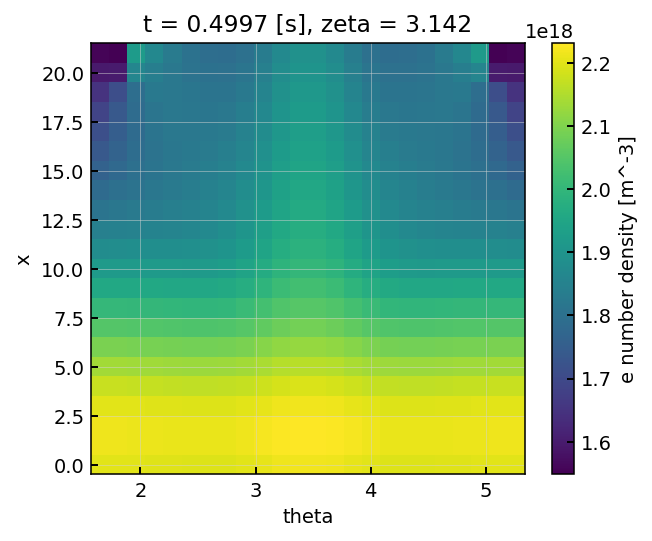

In [10]:
ds["Ne"].plot()

# Read Hermes-3

In [3]:
hr = dict()
for name in cs.keys(): 
    print(name)
    hr[name] = Hermesdata()
    hr[name].read_case(cs[name].ds.isel(t=-1))

    
    ds = cs[name].ds
    ds = calculate_radial_fluxes(ds, new_afn = True)
    # ds = calculate_target_fluxes(ds)
    ds = reverse_pfr_fluxes(ds)

tune


NameError: name 'Hermesdata' is not defined

# Convergence

In [18]:
%matplotlib inline

In [5]:
cs.keys()

dict_keys(['addc', 'addc_4x', 'addc_longer', 'no_Fcx'])

C:\Users\mikek\AppData\Local\Temp\ipykernel_28644\137069378.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = [plt.cm.get_cmap("plasma", tres)(x) for x in range(tres)]


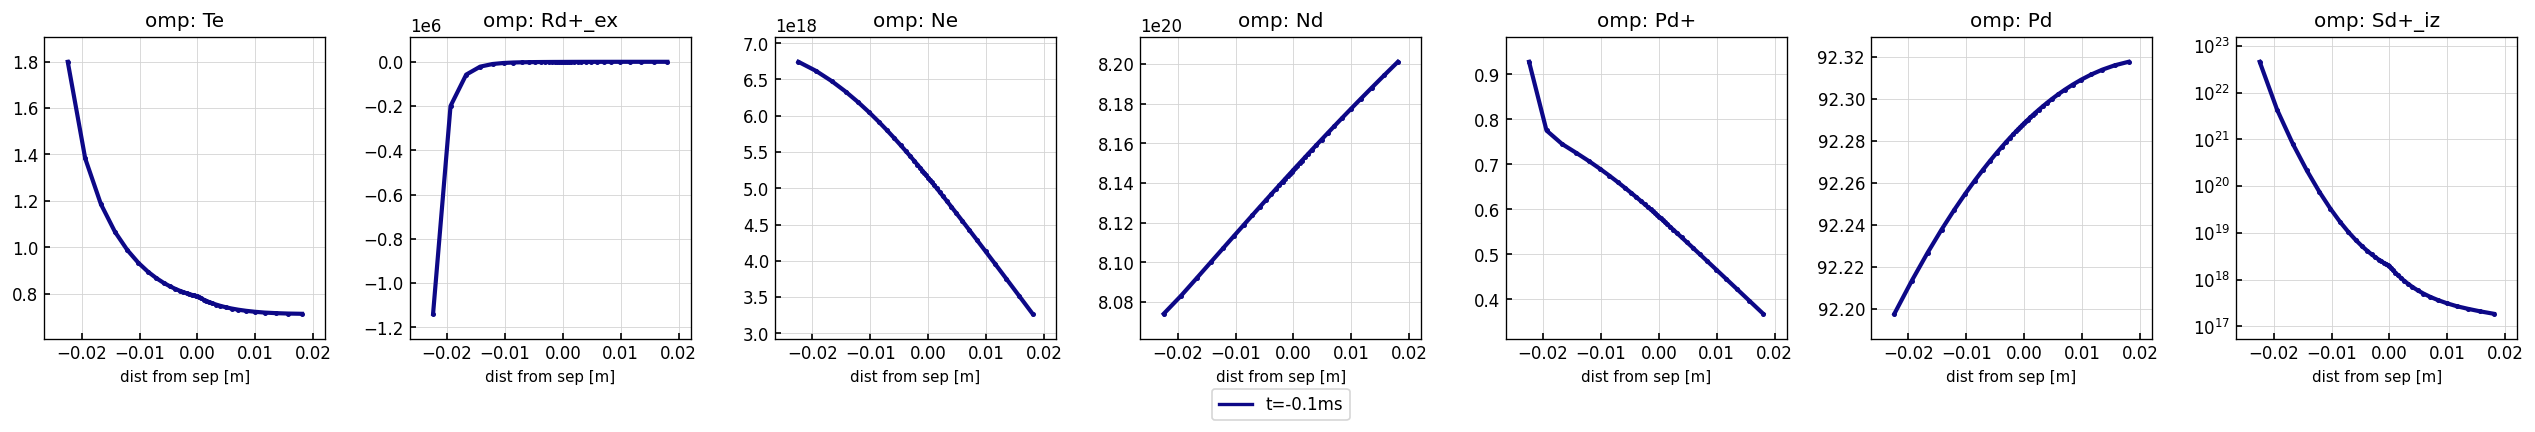

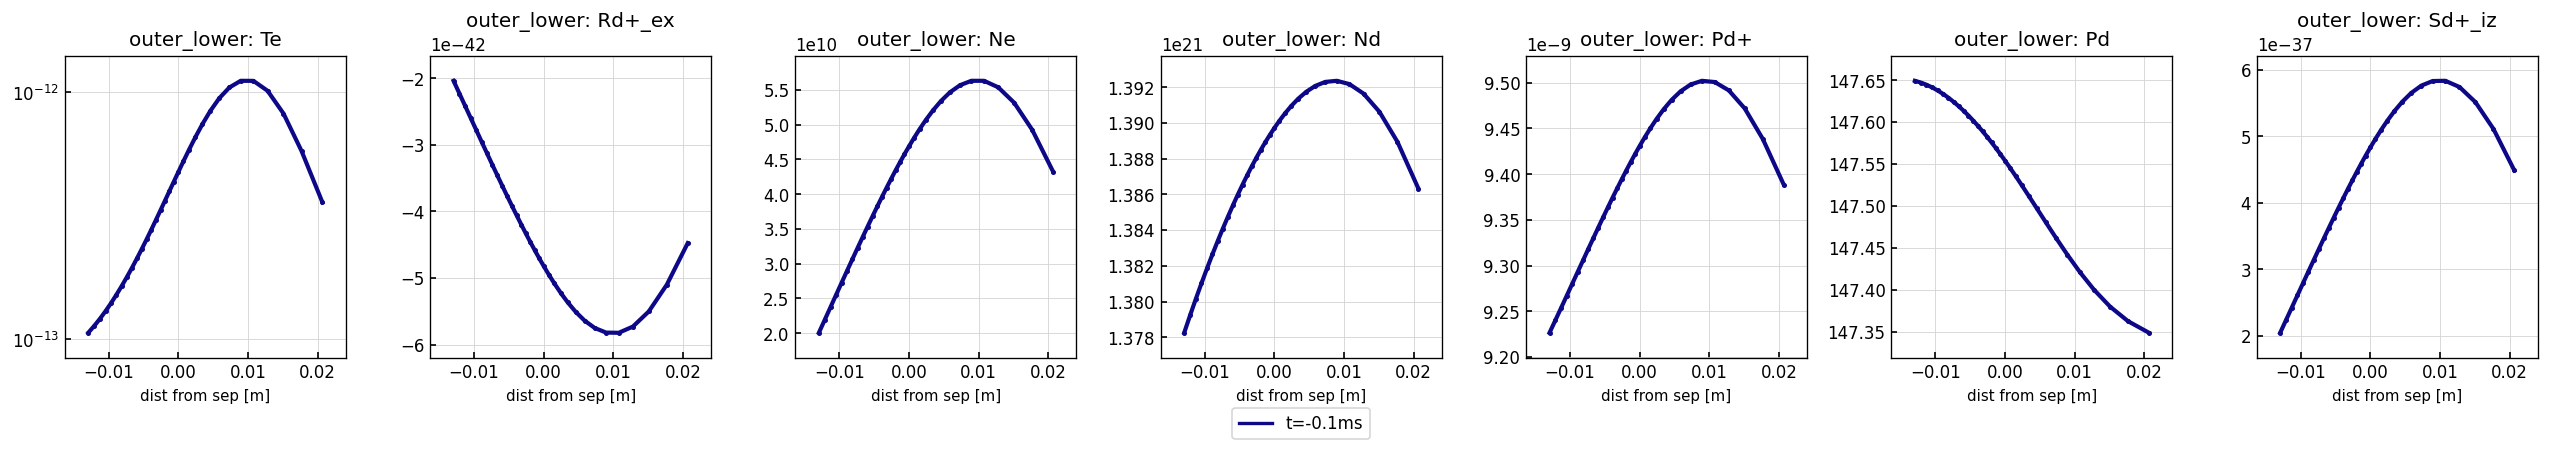

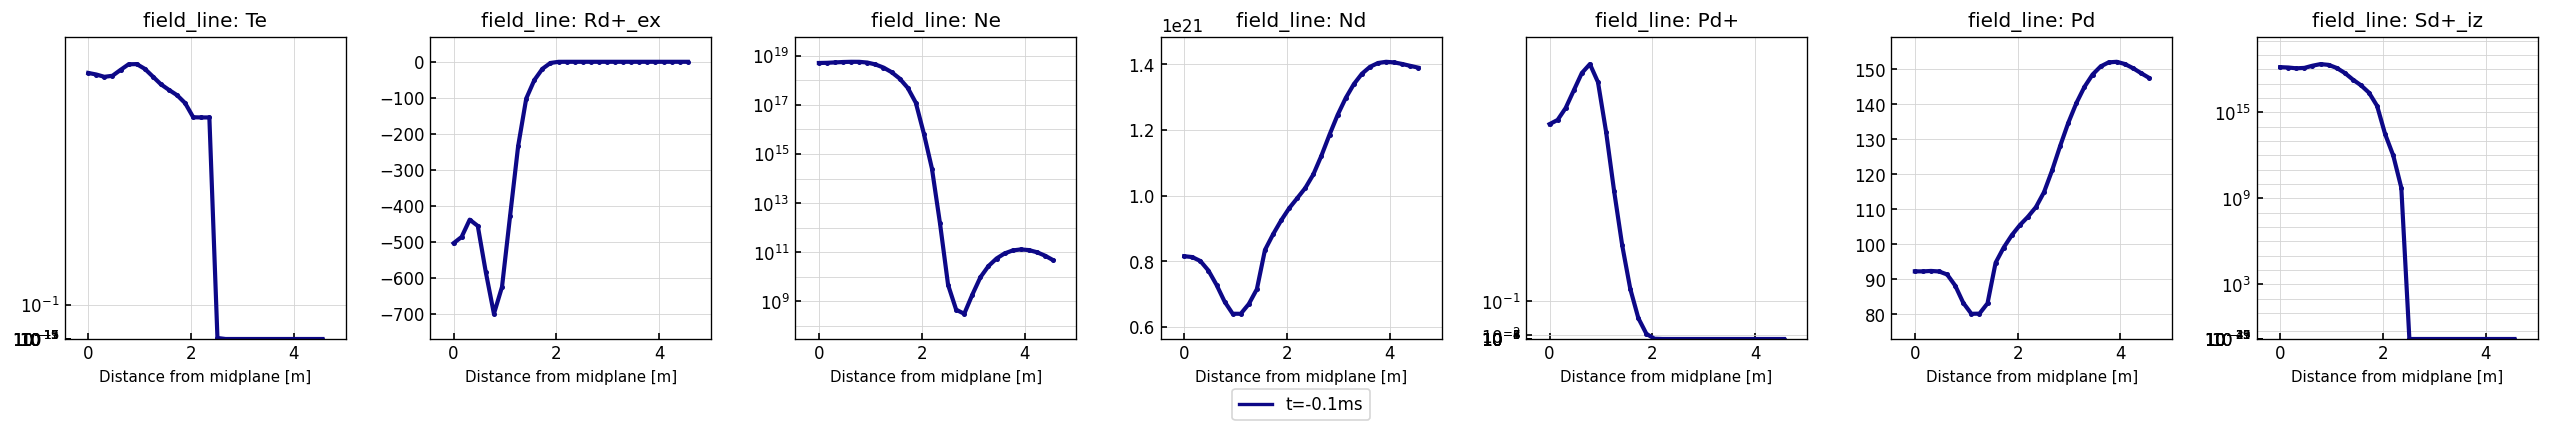

In [16]:

ds = cs["fix"].ds
# ds = ds2
tlen = ds.dims["t"]
tres = 10
ts = np.linspace(0, tlen-1, tres, dtype = int)
colors = [plt.cm.get_cmap("plasma", tres)(x) for x in range(tres)]

toplot = {}
for t in [-1]:
# for t in ts:
    toplot[f"t={t/10}ms"] = ds.isel(t=t, x = slice(2,-2))

lineplot(
    toplot,
    clean_guards = False,
    params = ["Te", "Rd+_ex", "Ne", "Nd", "Pd+", "Pd", "Sd+_iz"],
    regions = ["omp", "outer_lower", "field_line"],
    colors = colors
)

In [5]:
cs.keys()

dict_keys(['tune'])

C:\Users\mikek\AppData\Local\Temp\ipykernel_39224\2294513294.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors1 = [plt.cm.get_cmap("plasma", tres)(x) for x in range(tres)]
C:\Users\mikek\AppData\Local\Temp\ipykernel_39224\2294513294.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors2 = [plt.cm.get_cmap("viridis", tres)(x) for x in range(tres)]


(3.0, 0.0)

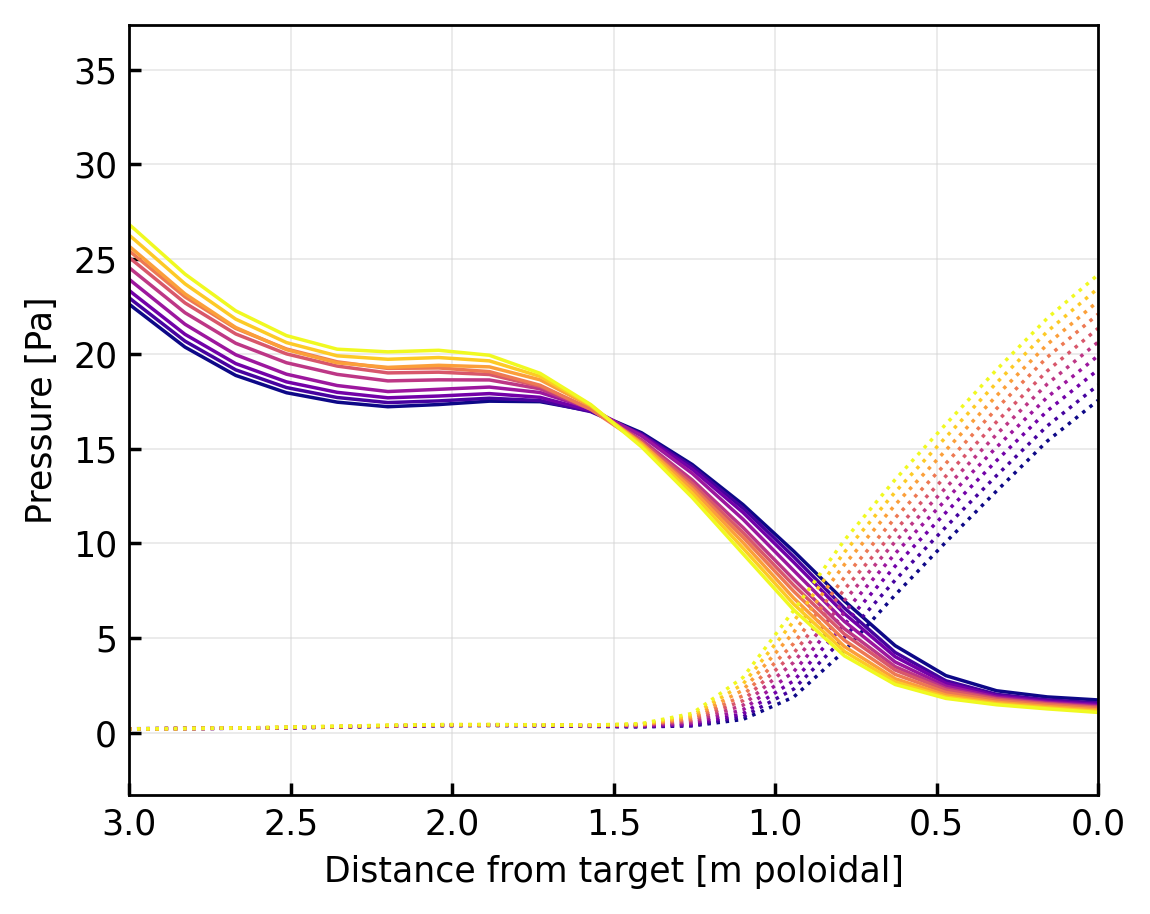

In [8]:
ds = cs["tune"].ds
tlen = ds.dims["t"]
tres = 10
ts = np.linspace(0, tlen-1, tres, dtype = int)
colors1 = [plt.cm.get_cmap("plasma", tres)(x) for x in range(tres)]
colors2 = [plt.cm.get_cmap("viridis", tres)(x) for x in range(tres)]

toplot = {}
for t in ts:
    toplot[f"t={t/10}ms"] = ds.hermesm.select_custom_sol_ring(ds.metadata["ixseps1"], "outer_lower").squeeze().isel(t=t)

fig, ax = plt.subplots(dpi = 250)

for i, name in enumerate(toplot):
    reg = toplot[name]
    xplot = reg.coords["theta"][-1] - reg.coords["theta"]

    ax.plot(xplot, reg["Pd+"], color = colors1[i], lw = 1.0)
    ax.plot(xplot, reg["Pd"], color = colors1[i], lw = 1.0, ls = ":")

ax.set_xlim(ax.get_xlim()[::-1])
ax.set_xlabel("Distance from target [m poloidal]")
ax.set_ylabel("Pressure [Pa]")
ax.set_xlim(3,0)
# ax.set_ylim(-0.5e4, 5.2e4)

# Front position analysis

In [29]:
for name in cs:
# for name in ["addc_4x"]:
    cs[name].ds.hermesm.get_front_positions(more_fronts = True)


In [32]:
cs.keys()

dict_keys(['addc', 'addc_4x', 'no_Fcx'])

In [28]:
for name in cs:
    if name != "no_Fcx":
        cs[name].ds["front_poldist_5eV"].plot(label = name)

plt.legend()

KeyError: 'front_poldist_5eV'

In [12]:
ds["front_poldist_5eV"].coords

Coordinates:
  * t        (t) float64 0.2426 0.2427 0.2428 0.2429 ... 0.2745 0.2746 0.2747
    zeta     float64 3.142

Text(0.5, 0, 't [ms]')

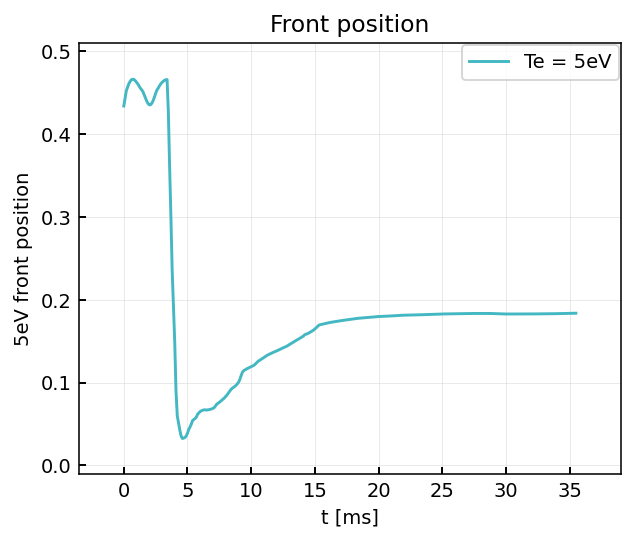

In [46]:

# ds = cs["addc_4x"].ds
ds = ds2.isel(t=slice(30,None))
fig, ax = plt.subplots()
ax.plot((ds["t"] - ds["t"][0])*1000, ds["front_poldist_5eV"], label = "Te = 5eV")
# ds["front_poldist_5eV"].plot(ax = ax, label = "Te = 5eV")
# ds["front_poldist_Rpeak"].plot(ax = ax, label = "Radiation peak")
# ds["front_poldist_Nepeak"].plot(ax = ax, label = "Ne peak")
# ds["front_poldist_RECpeak"].plot(ax = ax, label = "Recombination peak")
ax.legend()
ax.set_ylabel("5eV front position")
ax.set_title("Front position")
ax.set_xlabel("t [ms]")

In [66]:
for col in df.columns:
    if col != "t":
        df[col] = dist[-1] - df[col]


In [69]:
df["t"] = df["t"] - df["t"].iloc[0]

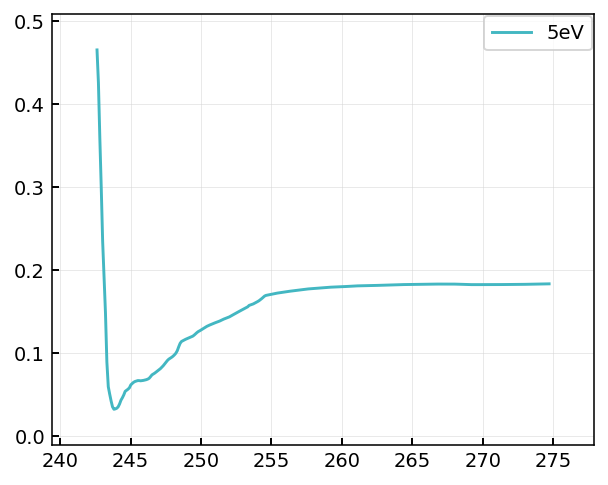

In [6]:
fig, ax = plt.subplots()

for col in df.columns:
    if col != "t":

        ax.plot(df["t"]* 1000, df[col], label = col)

ax.legend()

# Compare cases

In [6]:
cs.keys()

dict_keys(['allfields', 'addc'])

In [56]:
%matplotlib inline

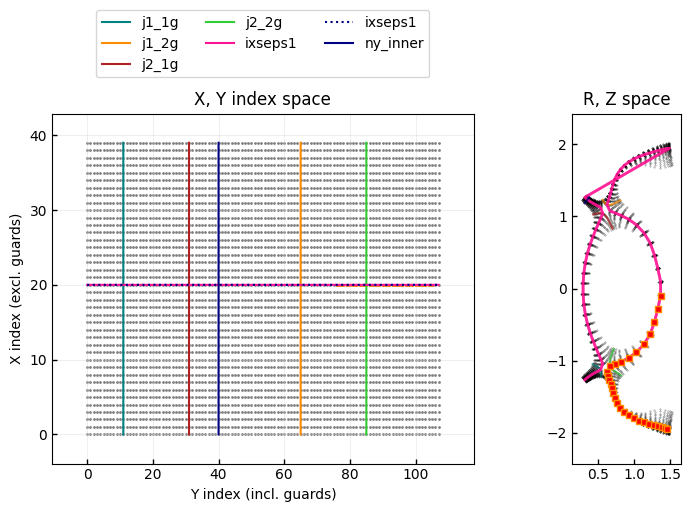

In [65]:
plot_selection(ds, reg)

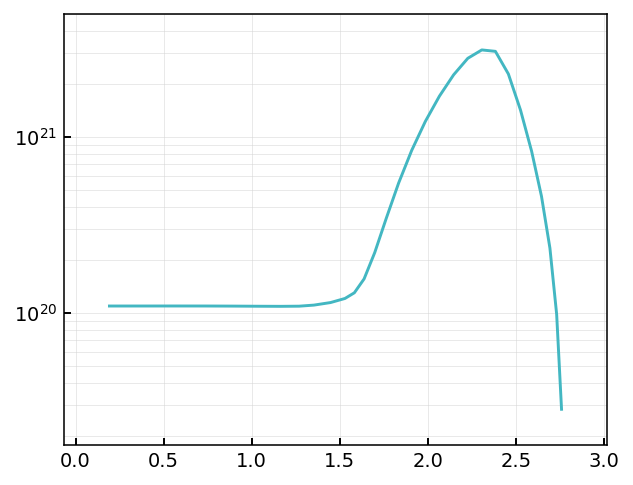

In [76]:
ds = cs["addc"].ds
reg = ds.hermesm.select_custom_sol_ring(19, "outer_lower").isel(t=-1).squeeze()

fig, ax = plt.subplots()

dist = reg["dpol"].cumsum()

# ax.plot(dist, reg["Ne"] * reg["Te"] * constants("q_e"))
ax.plot(dist, reg["Ne"])

# ax.set_xlim("Poloidal 
ax.set_yscale("log")

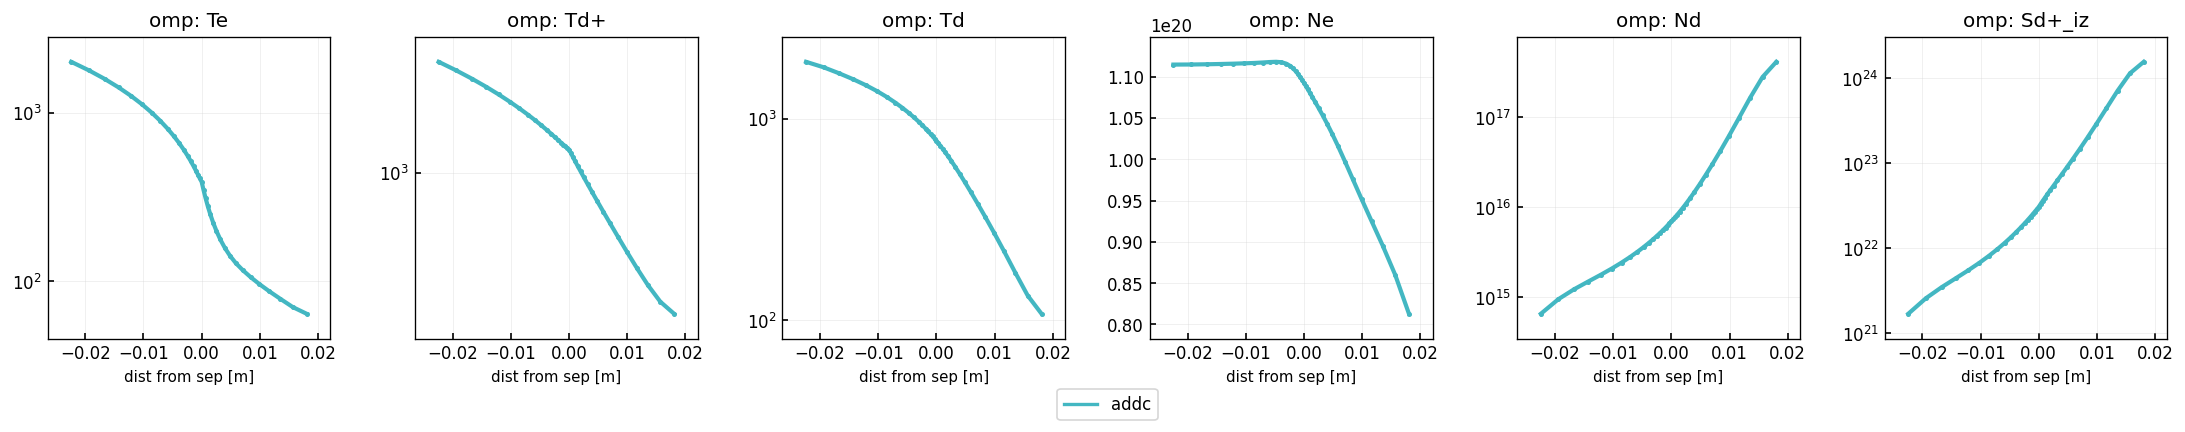

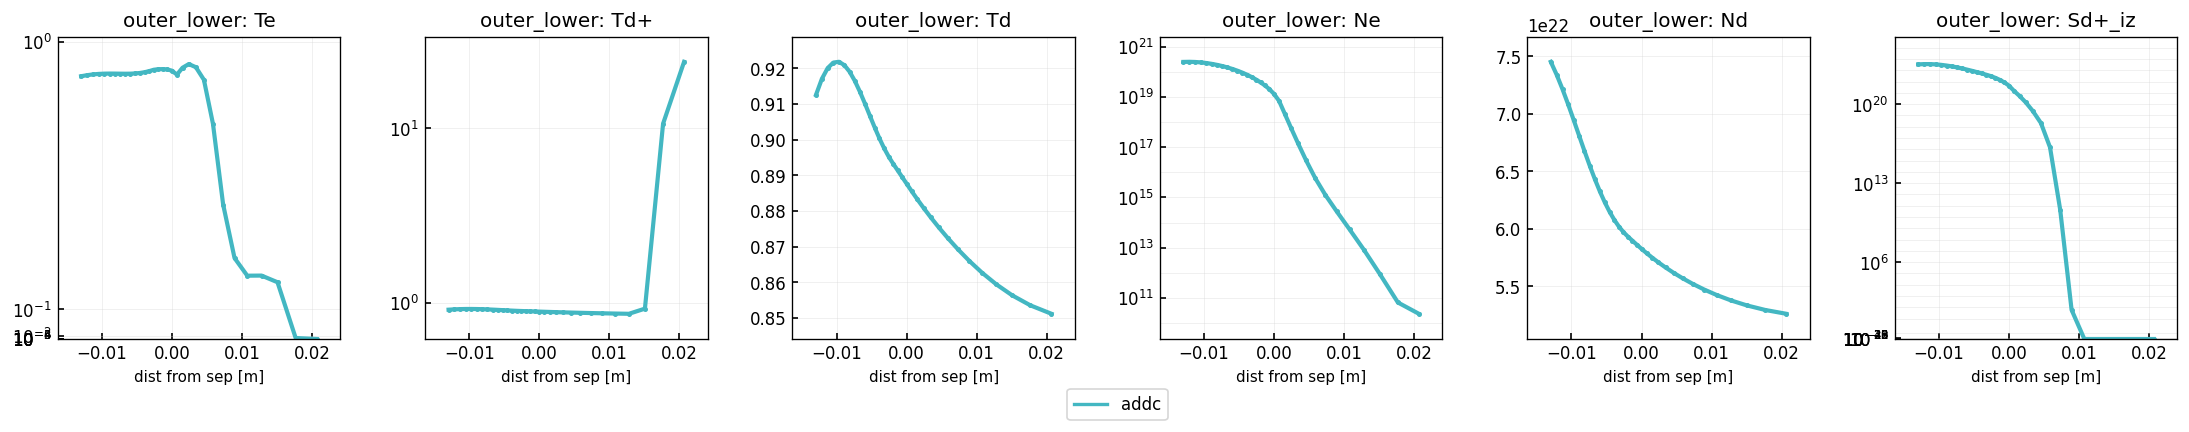

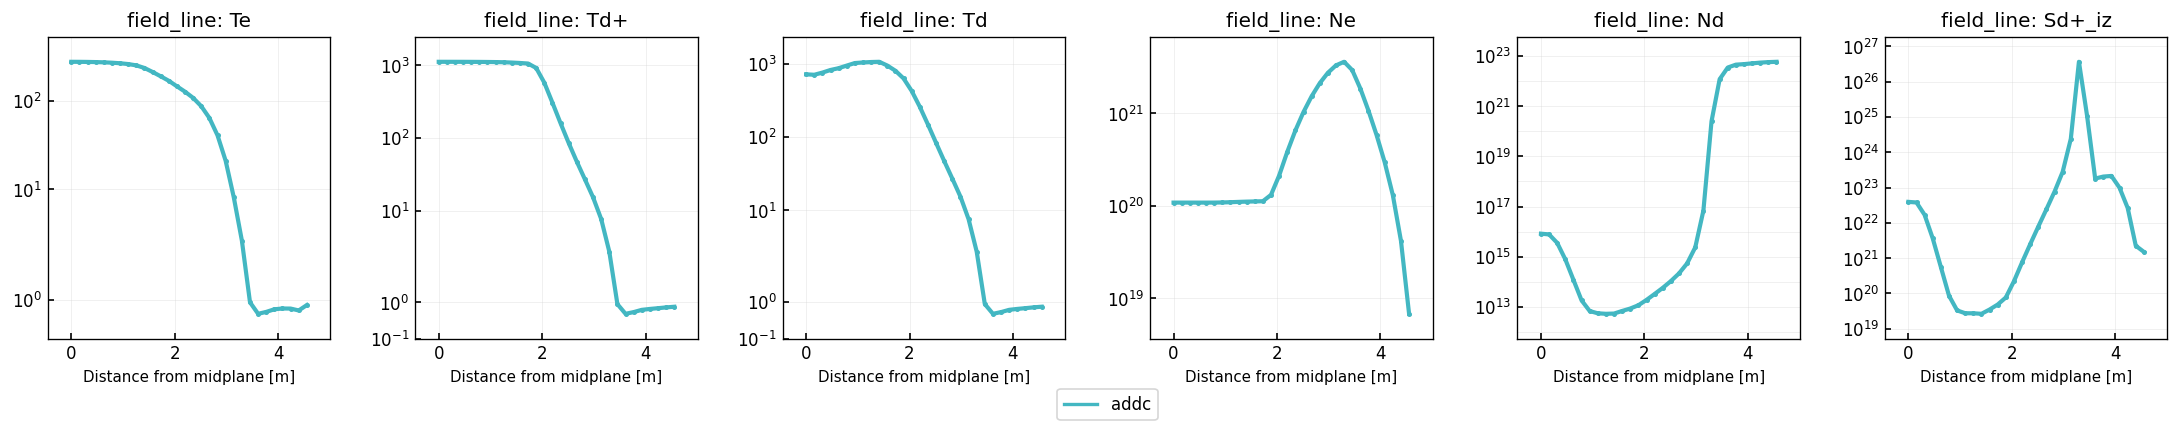

In [81]:
toplot = {}
for case in ["addc"]:
    toplot[case] = cs[case].ds.isel(t=-1, x = slice(2,-2))


lineplot(
    toplot,
    clean_guards = False,
    params = ["Te", "Td+", "Td", "Ne", "Nd", "Sd+_iz"],
    # params = ["Td", "Nd", "Pd"],
    regions = ["omp", "outer_lower", "field_line"],
)

# Performance

In [28]:
%matplotlib inline

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Sim time [ms]')

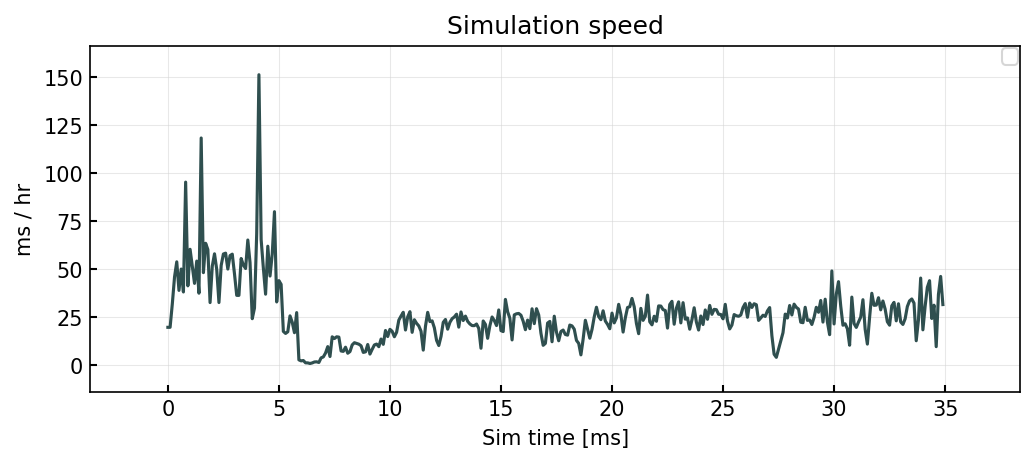

In [30]:
fig, ax = plt.subplots(figsize=(8,3), dpi = 150)


ds = cs["tune_4x"].ds.isel(t=slice(-350,None))
m = ds.metadata
# data = ds.hermesm.select_region("outer_midplane_a")["Ne"].isel(x=10)
wtime = ds["wtime"]
t = ds["t"].values * 1000   # ms
stime = np.diff(t, prepend = t[0])  
ms_per_24hrs = (stime) / (wtime/(60*60))  # ms simulated per 24 hours
ms_per_24hrs[0] = ms_per_24hrs[1]
ax.plot(t - t[0], ms_per_24hrs, c = "darkslategrey")
    
ax.legend()
ax.set_title("Simulation speed")
ax.set_ylabel("ms / hr")
ax.set_xlabel("Sim time [ms]")
# ax.set_yscale("log")



In [32]:
ds.metadata["ny"]

100

In [20]:
%matplotlib inline

# 2D plot

In [10]:
cs.keys()


dict_keys(['tune'])

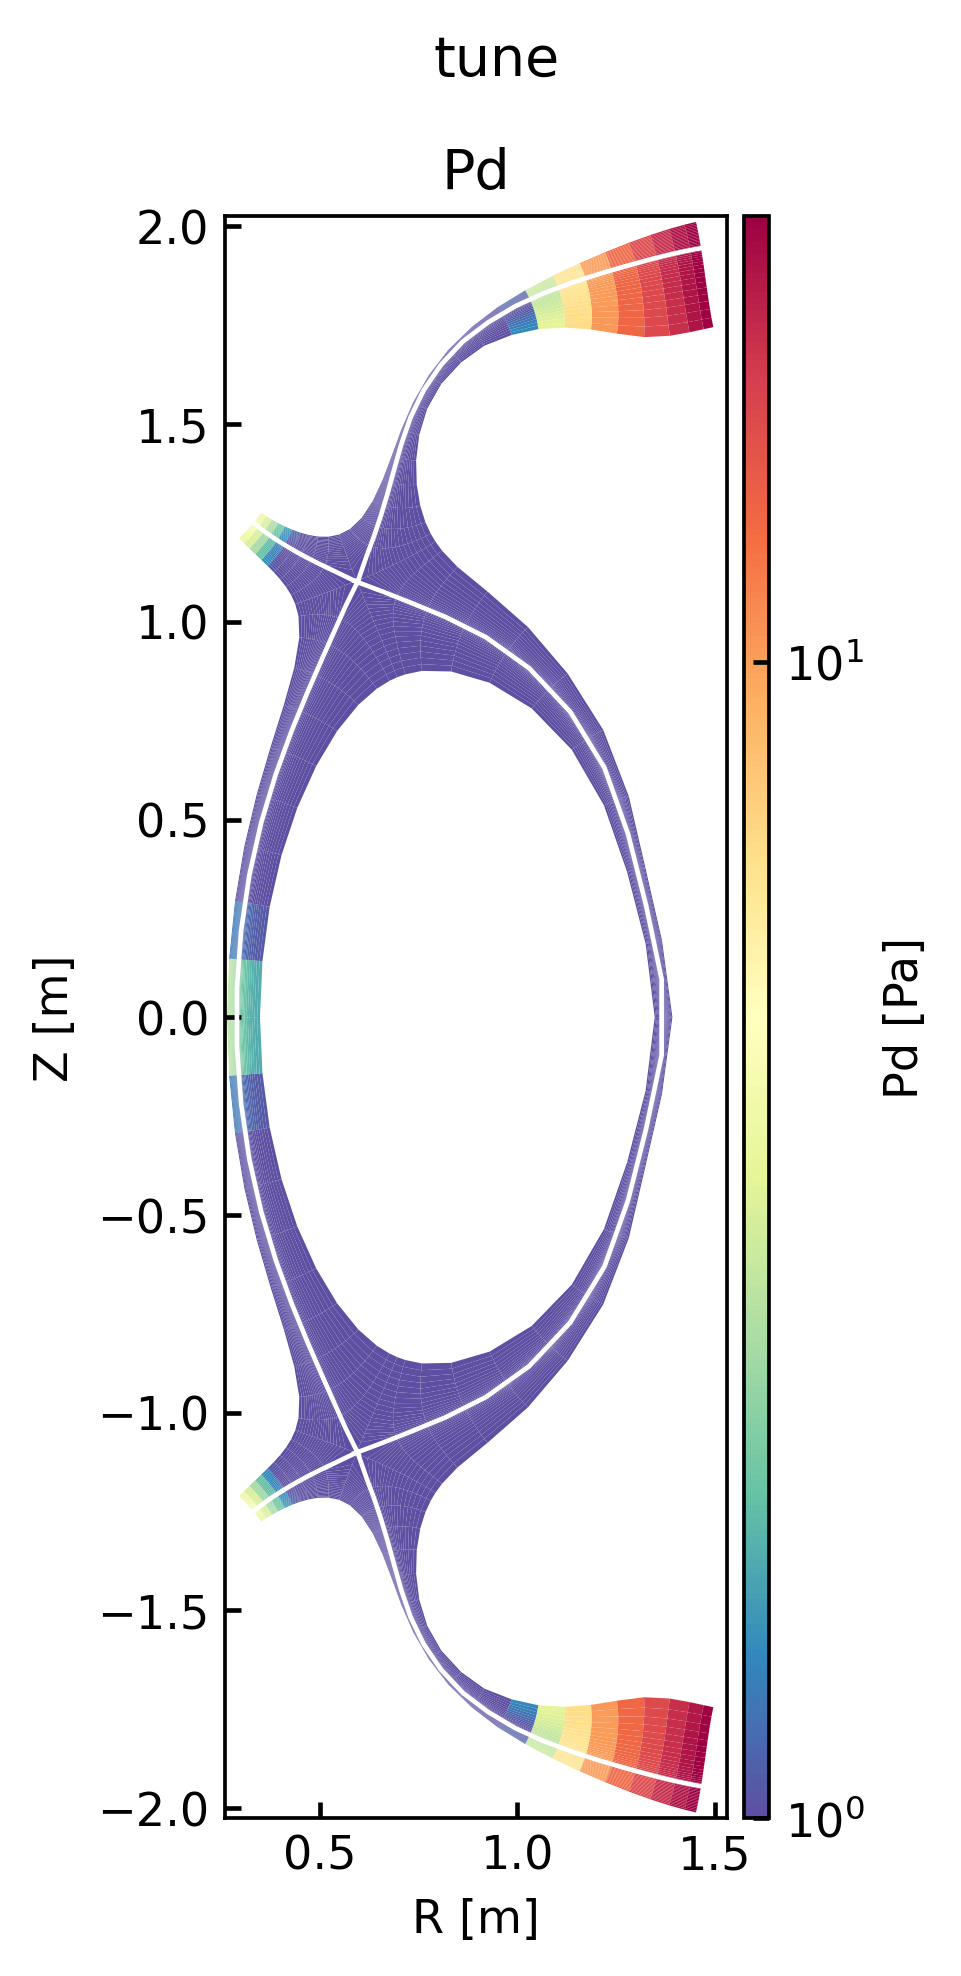

In [11]:


# cs["allfields"].ds["Rtot"] = cs["allfields"].ds["Rd+_ex"]*-1
# cs["addc"].ds["Rtot"] = cs["addc"].ds["Rd+_ex"]*-1 + cs["addc"].ds["Rc"]
# cs["allfields"].ds["Rc"] = 0
# cs["allfields"].ds["Rc"].attrs = cs["allfields"].ds["Rd+_ex"].attrs

for case in ["tune"]:
    ds = cs[case].ds.isel(t=-1)
    plot2d(
        [
            # dict(data = ds["Ne"], vmin = 1e18),
            dict(data = ds["Pd"], vmin = 1),
            # dict(data = ds["Rc"]),
            # dict(data = ds["Rtot"]),
            # dict(data = ds["Nd"]),
            ], 
            # ylim = (-2.1, -0.75),

            title = case,
            margins = (100, 100),
            dpi = 500,
            scale = 1.5,
            grid = False)

In [4]:
cs.keys()

dict_keys(['tune'])

c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\IPython\core\events.py:93: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  func(*args, **kwargs)


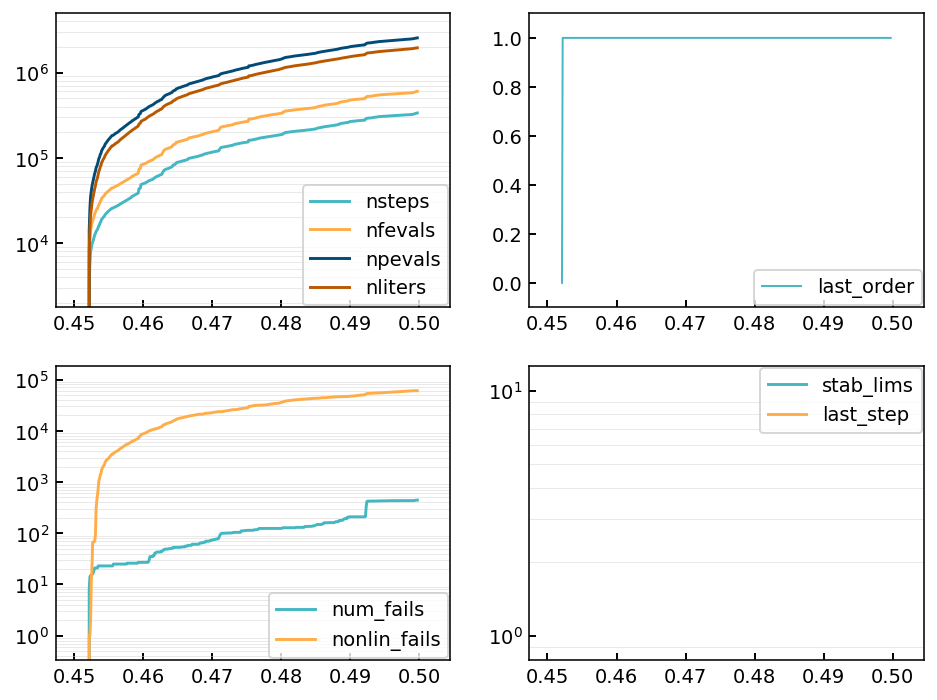

In [8]:
diagnose_cvode(cs["tune"].ds)

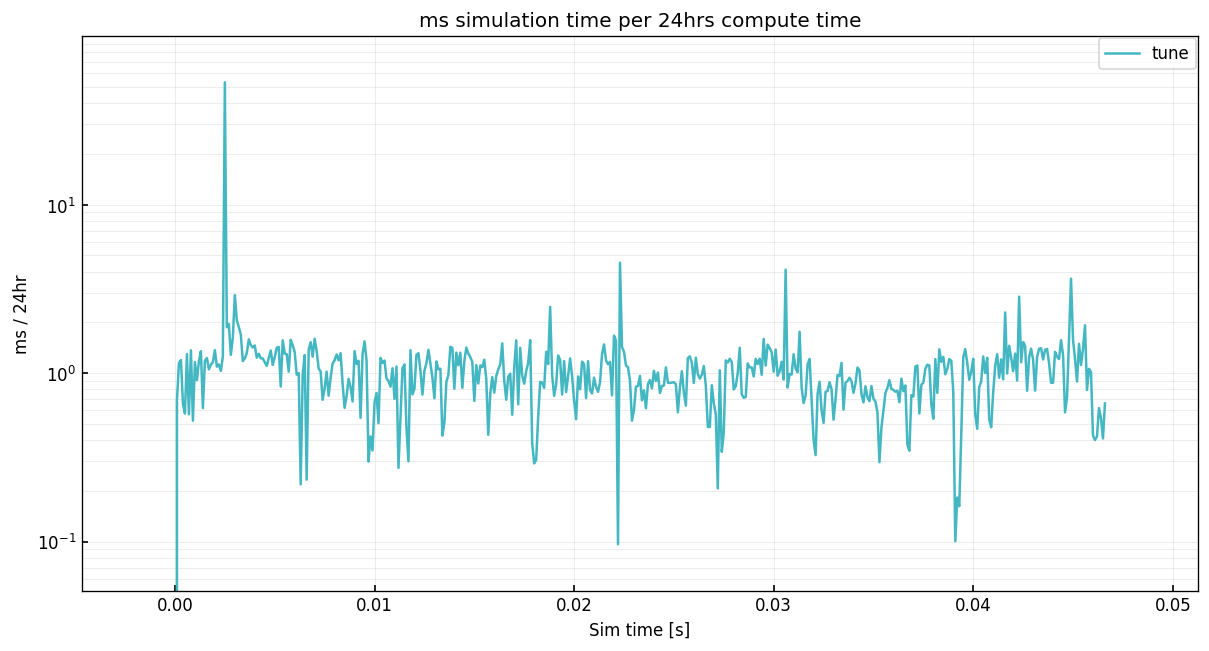

In [3]:
plot_performance(cs)

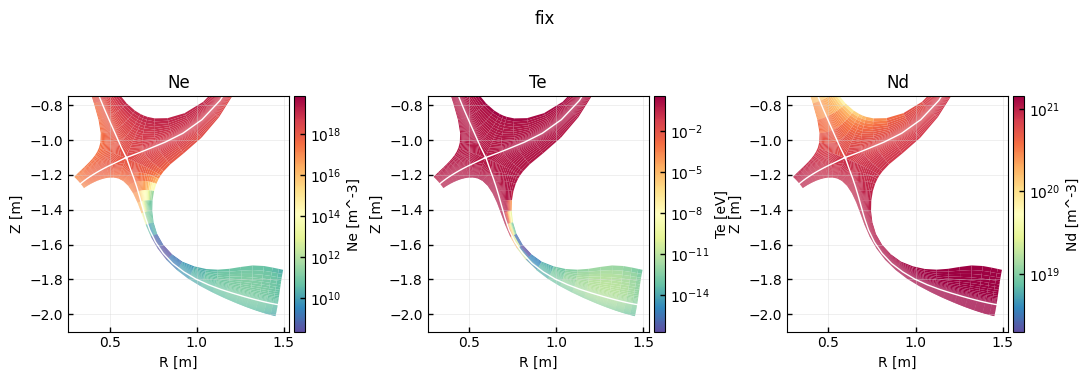

In [6]:


# cs["allfields"].ds["Rtot"] = cs["allfields"].ds["Rd+_ex"]*-1
# cs["addc"].ds["Rtot"] = cs["addc"].ds["Rd+_ex"]*-1 + cs["addc"].ds["Rc"]
# cs["allfields"].ds["Rc"] = 0
# cs["allfields"].ds["Rc"].attrs = cs["allfields"].ds["Rd+_ex"].attrs

for case in cs:
    ds = cs[case].ds.isel(t=-1)
    plot2d(
        [
            dict(data = ds["Ne"]),
            dict(data = ds["Te"]),
            # dict(data = ds["Rc"]),
            # dict(data = ds["Rtot"]),
            dict(data = ds["Nd"]),
            ], 
            ylim = (-2.1, -0.75),
            title = case,
            dpi = 100)

In [37]:
ds2 = xr.concat([cs["addc"].ds, cs["addc_4x"].ds], dim = "t")

# Animations

In [9]:
%matplotlib widget

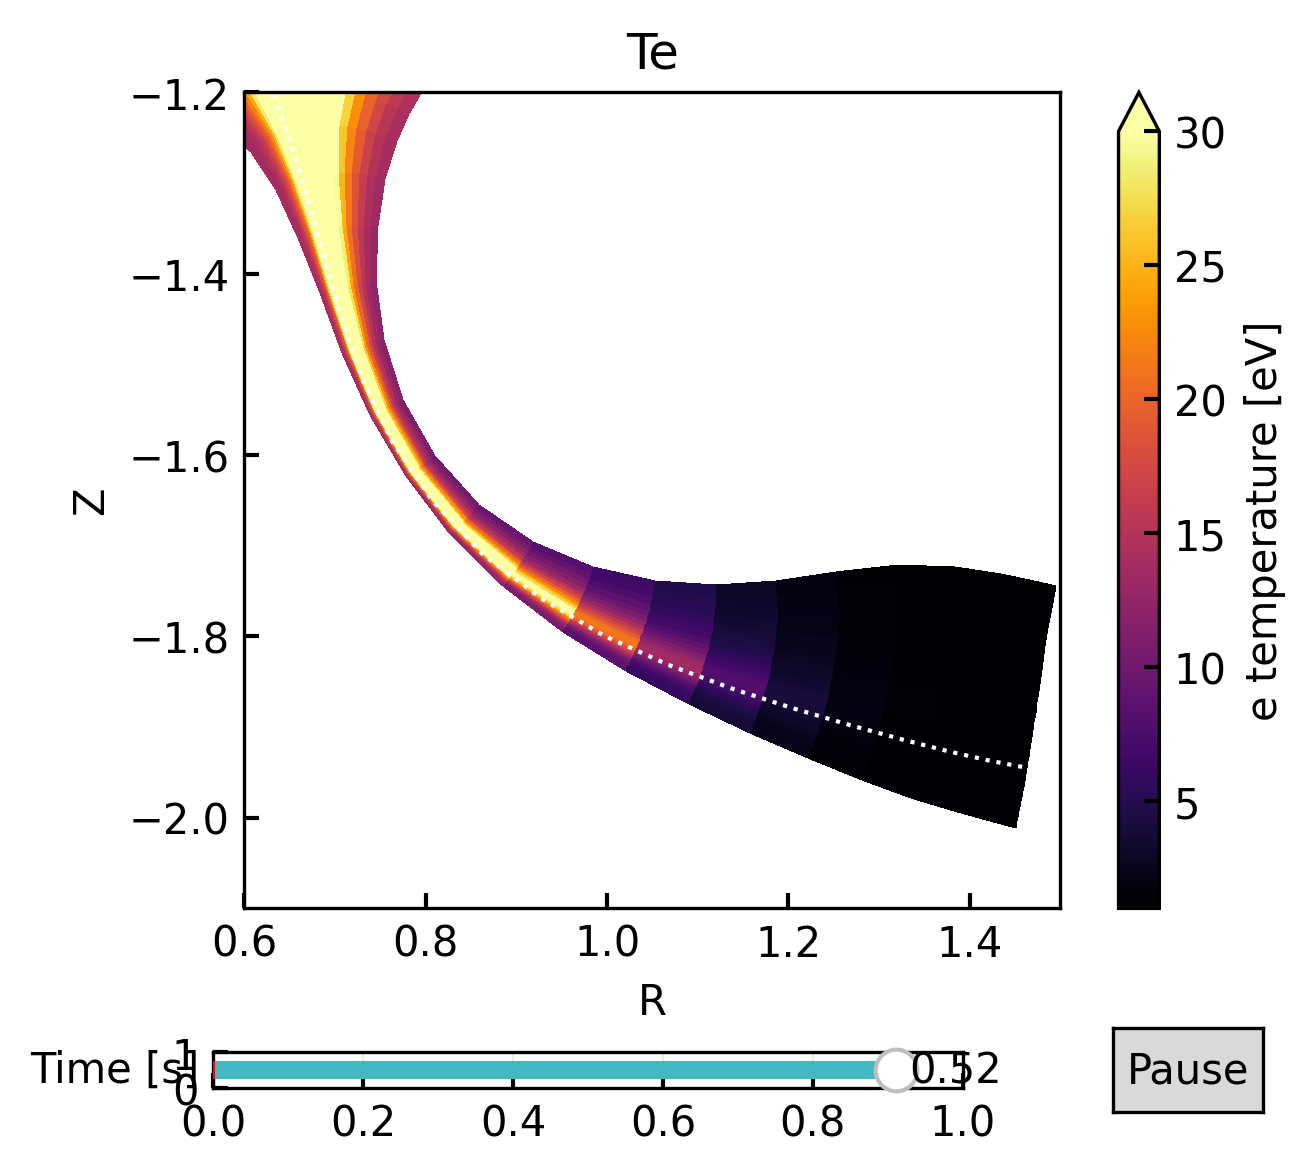

No such comm: 796f69eab2b34668b92bac88102cb349


In [26]:
plt.close("all")

# ds = ds2.isel(t=slice(30,None))
ds = cs["tune_4x"].ds.isel(t=slice(-350,-100))

fig, ax = plt.subplots(dpi = 300)
ax.set_ylim(-2.1, -1.2)
ax.set_xlim(0.6, 1.5)

# ax.set_ylim(-2.1, 0.2)
ax.grid(which = "both", visible = False)

anim = xbout.animate_poloidal(abs(ds["Te"].hermesm.clean_guards()), ax = ax, 
    targets = False, cmap = "inferno",   # PuOr 
    vmin = 1, vmax = 30,     # Te
    # vmin = 1e17, vmax = 5e17,  # Ne
    # vmin = 1e0, vmax = 5e4,    # P
    # vmin = 1e26, vmax = 1e22,    # Sd+_iz
    # vmin = 1e4, vmax = 2e6,     # Rd+_ex
    fps = 30, logscale = False,
    separatrix_kwargs = dict(color = "white", linestyle = ":", linewidth = 1),
    extend = "max",
    save_as = r"C:\Users\mikek\OneDrive\Project\collab\tech\cases\mastu2d\tune_4x_Te"
    # save_as = r"C:\Users\mikek\OneDrive\Project\collab\tech\cases\mastu2d\tune_4x_Rd+_ex"
)
# ax.set_ylim(-2.2,-0.7)


In [32]:
%matplotlib inline

In [9]:
ds["Te"].data.shape

(61, 40, 108)

In [23]:
m = ds.metadata
x_sep = m["ixseps1"]

j2_2g = m["jyseps2_2"] + m["MYG"] * 3
j1_2g = m["jyseps1_2"] + m["MYG"] * 3

y_omp = int((j2_2g - j1_2g) / 2) + j1_2g

positions = []

tsteps = ds["Te"].data.shape[0]

for t in range(tsteps):
    fieldline = ds["Rd+_ex"].values[t, x_sep, slice(y_omp, -m["MYG"])]

    idx = np.argmin(abs(fieldline - fieldline.max()))
    print(idx)

fieldline.shape

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
ds["Rd+_ex"].values.shape

In [ ]:
solpscases = {
    # "base" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5"),
    "noiz_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16"),
    # "gammai_2.5" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00"),
    # "dpuff_1e22" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22"),
    # "dpuff_5e21" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=5.0E+21"),
    # "no_fast_reflec" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.Pf=0"),
    # "nsep_2e19" : os.path.join(onedrive_path,r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=2E+19"),
    # "nsep_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=3E+19"),
    # "narrow_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent"),
    # "no_visc" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent.b2tqca_phm0=0"),
    # "16x_mc" : os.path.join(onedrive_path, r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.xxx.BCCON=16.core_extent.MC.histories.x16-ish.NOT.converged"),
    "tightwall_2e19" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_MK\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.NESEPM=2.0E+19",
    "tightwall_noD2_1e19" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_MK\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.NESEPM=1.0E+19.NO.D2",
    "tightwall_noD2_2e19" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_MK\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.NESEPM=2.0E+19.NO.D2",
    "tightwall_noD2_3e19" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_MK\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.NESEPM=3.0E+19.NO.D2",
    
}

sp = dict()

for name in solpscases:
    sp[name] = SOLPSdata()
    # sp[name].read_last10s(solpscases[name])
    sp[name].read_from_case(solpscases[name])